## Creating Dataset for Topic Modelling

In [16]:
import re
import pandas as pd

In [17]:
from langchain_community.llms import Ollama 

llm = Ollama(model="llama3.1")

In [22]:
prompt = """ 
Imagine you are a student going to take admissoin in Masters in Statistics programme in IIT Bombay this year and you a ton of queries in your mind related to sports, academics and culturals activities, facilities, courses and exposure in the college. I am trying to perfrom a topic modelling task on different sort of queries students can ask when they come in IIT Bombay.
1. I want the queries of generally 3 types, related to sports, academics and culturals. Help me in creating a dataset for this topic modelling task.
2. I want approximately 40-40 text queries in each topic, questions students may have doubt or want to know about, it can be anything, whether facilities, or competiotns or prgramms held in that topic, anything, minor to minor detail related ot IIT Bombay under those topics can be asked.
3. Be as creative as you can, go into fine to fine details in the topics when you are giving questions and also stick one question related to one topic only, do not mix them.

Give the output in JSON format like {"Sports" : [Ques1, Ques2, ...], "Academics" : [Ques1, Ques2, ...], "Culturals" : [Ques1, Ques2, ...]}.
"""

In [23]:
out = llm.invoke(prompt, stop=['<|eot_id|>'])

In [28]:
print(out)

Here's a dataset with 40 questions each in three categories: Sports, Academics, and Culturals.

```json
{
  "Sports": [
    "What sports facilities does IIT Bombay have?",
    "Does IIT Bombay have a cricket stadium?",
    "What kind of sports teams are there in IIT Bombay?",
    "Can students participate in intramural tournaments?",
    "Are sports scholarships available for students?",
    "How often do sports events take place on campus?",
    "Is there a gymnasium or workout space available?",
    "Do students have access to swimming pools or other aquatic facilities?",
    "Can I get involved in sports committees or organizations?",
    "What kind of sports equipment is provided by the college?",
    "Are there any inter-college sports competitions that IIT Bombay participates in?",
    "How do I join a sports team or club?",
    "Is there any provision for sports injuries or medical care?",
    "Can students get involved in coaching or mentoring roles in sports teams?",
    "What

In [58]:
import json

# Convert string to dictionary
data_dict = json.loads(out[104:-320])

# Initialize a list to store the rows
rows = []

# Iterate through the dictionary and populate rows
for topic, questions in data_dict.items():
    for question in questions:
        rows.append({"Question": question, "Label": topic})

# Create a pandas DataFrame
df = pd.DataFrame(rows)

In [61]:
df.to_csv("Topic Modelling Dataset 2.csv")

In [29]:
# Split the data into lines and initialize lists for topics and questions
lines = out.strip().split('\n')
questions = []
topics = []

# Initialize a variable to keep track of the current topic
current_topic = None

for line in lines:
    # Check if the line indicates a new topic
    if line.startswith('**') and line.endswith('**'):
        current_topic = line.split(' ')[0][2:]  # Get the topic name without asterisks
    elif re.match(r'^\d+\.\s', line):  # Match any line starting with a number followed by a period and space
        questions.append(line.strip())  # Add the question to the list
        topics.append(current_topic)  # Add the current topic to the list

# Create a DataFrame from the questions and topics
df = pd.DataFrame({
    'question': questions,
    'topic': topics
})

print(df)

                                              question          topic
0    1. What is the curriculum for the master's pro...      Academics
1    2. Can I take courses from other departments l...      Academics
2    3. How many credits do we need to complete per...      Academics
3    4. Is it possible to switch from one specializ...      Academics
4    5. Who are the professors teaching in our depa...      Academics
..                                                 ...            ...
145  26. Are there any opportunities for students t...  Miscellaneous
146  27. Can I get a refund if I drop out of an act...  Miscellaneous
147  28. How does the department support student we...  Miscellaneous
148  29. Which departments have access to funding f...  Miscellaneous
149  30. Are there any opportunities for students t...  Miscellaneous

[150 rows x 2 columns]


In [31]:
df['question'] = df['question'].str.split('. ', n=1).str[1]

In [42]:
df.sample(10)

,question,topic
145,Are there any opportunities for students to en...,Miscellaneous
147,How does the department support student wellne...,Miscellaneous
58,Is it possible to rent sports equipment like k...,Sports
104,Can I get a discount on club membership fees i...,Clubs
94,Can I get a refund if I drop out of a club due...,Clubs
67,How does the department promote diversity and ...,Culturals
116,Can I get a refund if I drop out of a club due...,Clubs
20,What are the key skills and knowledge areas ex...,Academics
30,Which sports facilities are available for stud...,Sports
51,Are there any sports-related events or tournam...,Sports


In [45]:
df.to_csv('Topic Modelling Dataset.csv', index=False)

## Data Preprocessing

In [67]:
df = pd.read_csv("Topic Modelling Dataset 2.csv")

In [72]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [76]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean and preprocess the text
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join the tokens back into a single string
    return ' '.join(tokens)

In [74]:
# Apply the preprocessing function to the 'Question' column
df['Cleaned_Question'] = df['Question'].apply(preprocess_text)

df.sample(5)

,Unnamed: 0,Question,Label,Cleaned_Question
28,28,Can I take courses from other departments or c...,Academics,take course department college within iit bombay
24,24,What kind of recognition or rewards are given ...,Sports,kind recognition reward given outstanding spor...
59,59,How do I get access to cultural facilities lik...,Culturals,get access cultural facility like auditorium a...
17,17,Is there any facility for indoor games like ta...,Sports,facility indoor game like table tennis pool etc
54,54,How do I know about upcoming deadlines for reg...,Culturals,know upcoming deadline registration performanc...


## Topic Modelling

In [62]:
import pandas as pd
import gensim
from gensim import corpora
import nltk
from nltk.corpus import stopwords
import string

In [63]:
df = pd.read_csv("Topic Modelling Dataset 2.csv")

In [139]:
custom_stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 
                    'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 
                    'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 
                    'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
                    'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 
                    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 
                    'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
                    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 
                    'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 
                    'with', 'about', 'against', 'between', 'into', 'through', 
                    'during', 'before', 'after', 'above', 'below', 'to', 'from', 
                    'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 
                    'again', 'further', 'then', 'once', 'here', 'there', 'when', 
                    'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 
                    'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 
                    'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 
                    'can', 'will', 'just', 'don', "don't", 'should', "should've", 
                    'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 
                    "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', 
                    "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', 
                    "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 
                    'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 
                    'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 
                    'won', "won't", 'wouldn', "wouldn't", "students", 'im', 'due', 'get']

def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = [word for word in text.split() if word not in custom_stopwords]
    return tokens

# Apply preprocessing to the questions
df['tokens'] = df['Cleaned_Question'].apply(preprocess)

In [140]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 1. Vectorize the cleaned questions using CountVectorizer (Bag-of-Words)
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['Cleaned_Question'])

# 2. Apply LDA
n_topics = 3  # You can change this depending on how many topics you expect
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

# 3. Extract topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 5
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, no_top_words)

# 4. Assign topics to each document
doc_topic_dist = lda.transform(X)
df['Topic'] = doc_topic_dist.argmax(axis=1)

# Display the DataFrame with assigned topics
df.sample(5)

Topic 0:
program course facility available rule
Topic 1:
student provision disability sport activity
Topic 2:
sport event cultural campus kind


,Unnamed: 0,Question,Label,Cleaned_Question,Topic
64,64,Can I get financial support for attending cult...,Culturals,get financial support attending cultural event...,2
18,18,Can I request for sports-related infrastructur...,Sports,request sportsrelated infrastructure developme...,2
6,6,Is there a gymnasium or workout space available?,Sports,gymnasium workout space available,0
25,25,Are there any specific rules for team selectio...,Sports,specific rule team selection tryout etc,0
29,29,Are there any exchange programs with foreign u...,Academics,exchange program foreign university available,0


In [141]:
def corpus_to_topics(corps, num_topics = 7):
    lda_model = gensim.models.LdaModel(corps, num_topics=num_topics, id2word=dictionary, passes=20)

    x = lda_model.print_topics(num_topics=-1)

    out = []
    for i in x:
        result = re.findall(r'"(.*?)"', i[1])
        out.append(result)

    for index, words in enumerate(out):
        print(f"The words associate with Topic:{index} are {words}")

In [143]:
corpus_to_topics(corpus, num_topics=3)

NameError: name 'corpus' is not defined

## GSDMM

In [90]:
from gsdmm import MovieGroupProcess

In [91]:
# Initialize GSDMM model
gsdmm = MovieGroupProcess(K=3, alpha=0.1, beta=0.3, n_iters=300)

# Prepare tokenized documents from the 'tokens' column
tokenized_documents = df['tokens'].tolist()

# Fit the model on the tokenized data
vocab_size = len(set(word for doc in tokenized_documents for word in doc))
doc_labels = gsdmm.fit(tokenized_documents, vocab_size)

In stage 0: transferred 37 clusters with 3 clusters populated
In stage 1: transferred 20 clusters with 3 clusters populated
In stage 2: transferred 7 clusters with 3 clusters populated
In stage 3: transferred 10 clusters with 3 clusters populated
In stage 4: transferred 10 clusters with 3 clusters populated
In stage 5: transferred 8 clusters with 3 clusters populated
In stage 6: transferred 8 clusters with 3 clusters populated
In stage 7: transferred 9 clusters with 3 clusters populated
In stage 8: transferred 9 clusters with 3 clusters populated
In stage 9: transferred 11 clusters with 3 clusters populated
In stage 10: transferred 8 clusters with 3 clusters populated
In stage 11: transferred 9 clusters with 3 clusters populated
In stage 12: transferred 12 clusters with 3 clusters populated
In stage 13: transferred 7 clusters with 3 clusters populated
In stage 14: transferred 8 clusters with 3 clusters populated
In stage 15: transferred 8 clusters with 3 clusters populated
In stage 16:

In [92]:
# Assign each document to its most probable topic
df['topic'] = [gsdmm.choose_best_label(doc)[0] for doc in tokenized_documents]

In [93]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

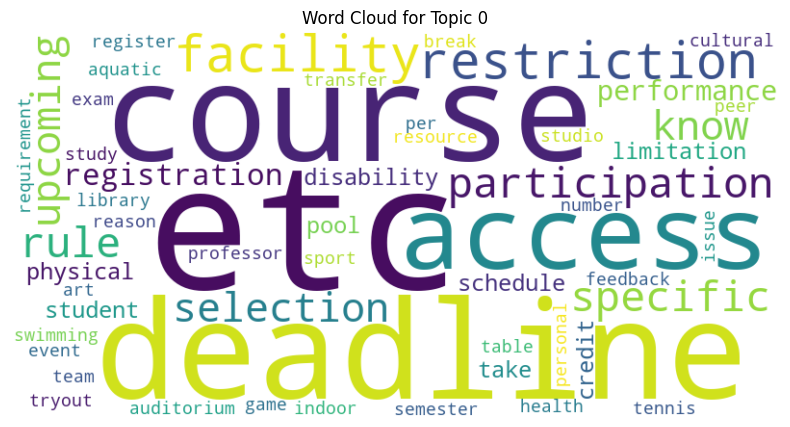

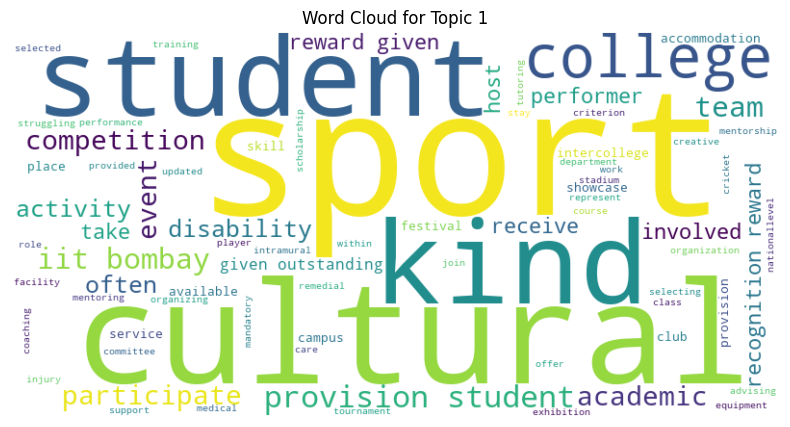

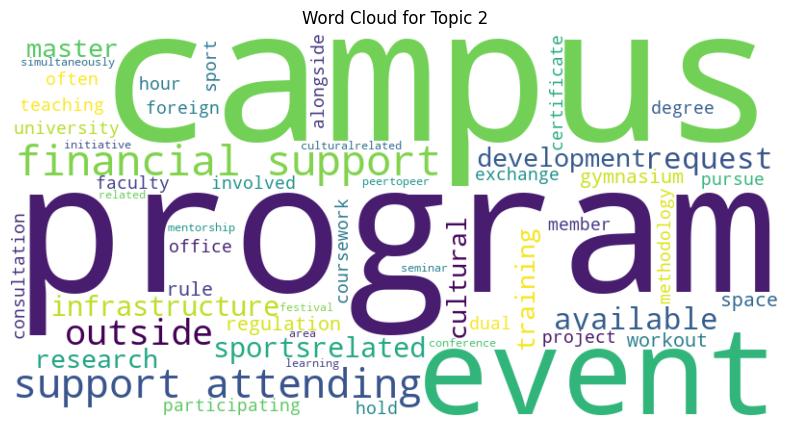

In [94]:
# Concatenate tokens into one string for each topic
def create_word_clouds_by_topic(df):
    grouped_data = df.groupby('topic')['tokens'].apply(lambda x: ' '.join([' '.join(tokens) for tokens in x]))

    # Create word clouds for each topic
    for topic, tokens in grouped_data.items():
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tokens)
        
        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Topic {topic}")
        plt.show()

# Call the function
create_word_clouds_by_topic(df)

In [95]:
df.sample(5)

,Unnamed: 0,Question,Label,Cleaned_Question,Topic,tokens,topic
31,31,Can I get involved in research projects alongs...,Academics,get involved research project alongside course...,1,"[involved, research, project, alongside, cours...",2
40,40,Can I take a break from studies due to persona...,Academics,take break study due personal reason health issue,0,"[take, break, study, personal, reason, health,...",0
6,6,Is there a gymnasium or workout space available?,Sports,gymnasium workout space available,0,"[gymnasium, workout, space, available]",2
20,20,Are there any restrictions on participation du...,Sports,restriction participation due physical limitat...,1,"[restriction, participation, physical, limitat...",0
60,60,Can I request for cultural-related infrastruct...,Culturals,request culturalrelated infrastructure develop...,2,"[request, culturalrelated, infrastructure, dev...",2


In [97]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.mixture import BayesianGaussianMixture

queries = df['Question'].to_list()

# Convert queries to word count vectors (Bag of Words representation)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(queries).toarray()

In [98]:
# Apply a Dirichlet Process Gaussian Mixture Model
dpgmm = BayesianGaussianMixture(n_components=4, weight_concentration_prior_type='dirichlet_process', max_iter=1000)
dpgmm.fit(X)

# Predict cluster assignments
cluster_labels = dpgmm.predict(X)
df["cluster_labels"] = cluster_labels

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Guassian Mixture Model

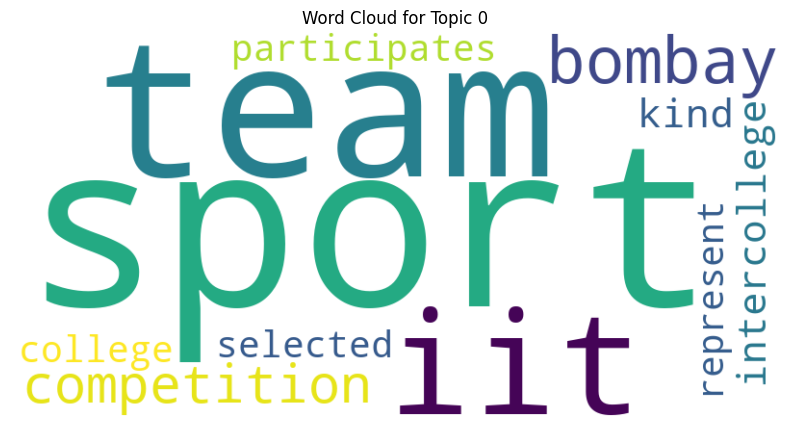

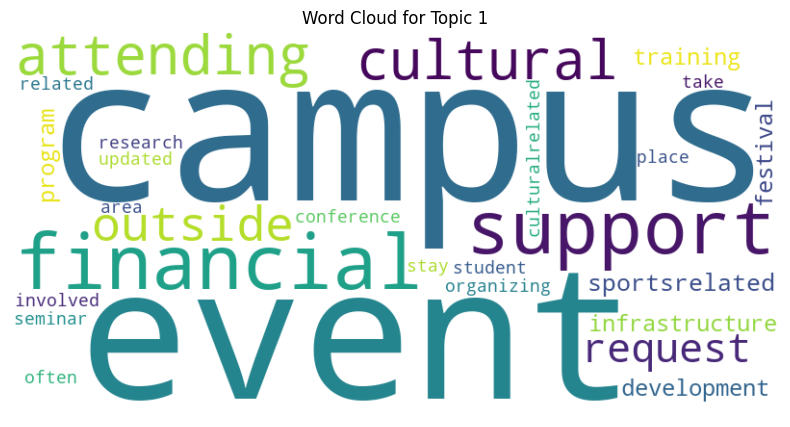

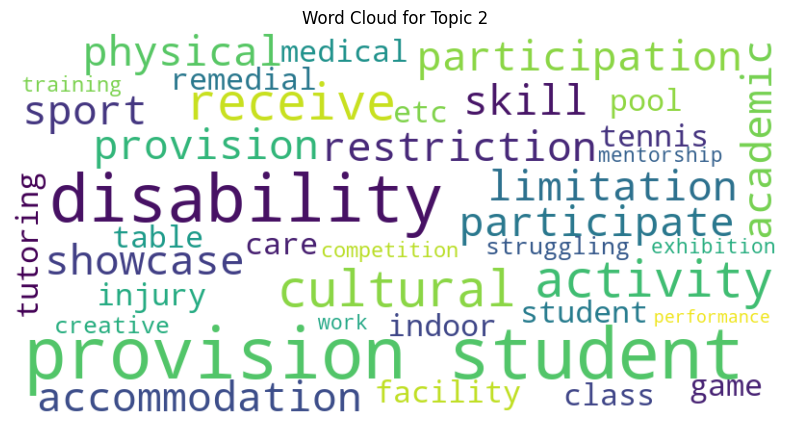

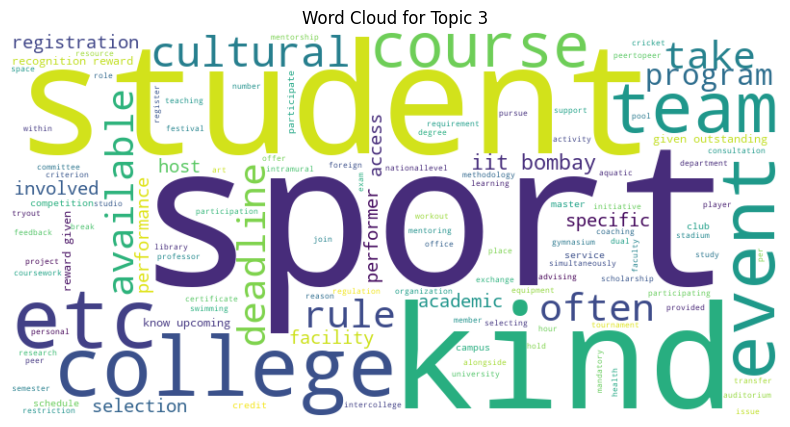

In [99]:
# Concatenate tokens into one string for each topic
def create_word_clouds_by_topic(df):
    grouped_data = df.groupby('cluster_labels')['tokens'].apply(lambda x: ' '.join([' '.join(tokens) for tokens in x]))

    # Create word clouds for each topic
    for topic, tokens in grouped_data.items():
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tokens)
        
        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Topic {topic}")
        plt.show()

# Call the function
create_word_clouds_by_topic(df)

## Sentence Embedding and Dimensionality Reduction

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [101]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [102]:
embeddings = model.encode(df['Question'].tolist())

In [105]:
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for plotting

# Fit PCA on the embeddings
reduced_embeddings = pca.fit_transform(embeddings)

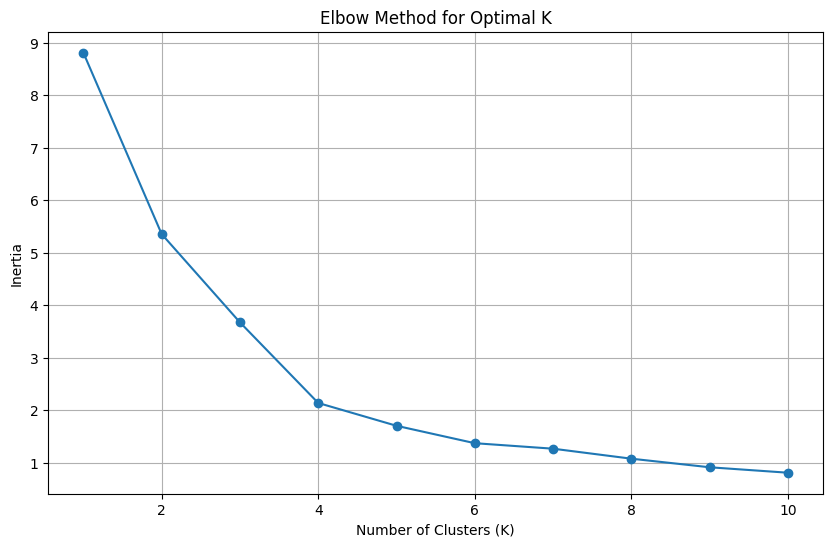

In [106]:
from sklearn.cluster import KMeans

# Determine the optimal number of clusters using the Elbow method
inertia = []
k_values = range(1, 11)  # Testing K values from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_embeddings)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [107]:
# Fit KMeans with the chosen number of clusters (e.g., K=3)
optimal_k = 3  # You can choose this based on the Elbow method results
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(reduced_embeddings)

# Get the cluster labels
df['cluster'] = kmeans.labels_

/var/folders/4y/skt5fj3x3gb1fb25wsg55_6m0000gn/T/ipykernel_6219/1389942149.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', optimal_k)  # Get colors for each cluster


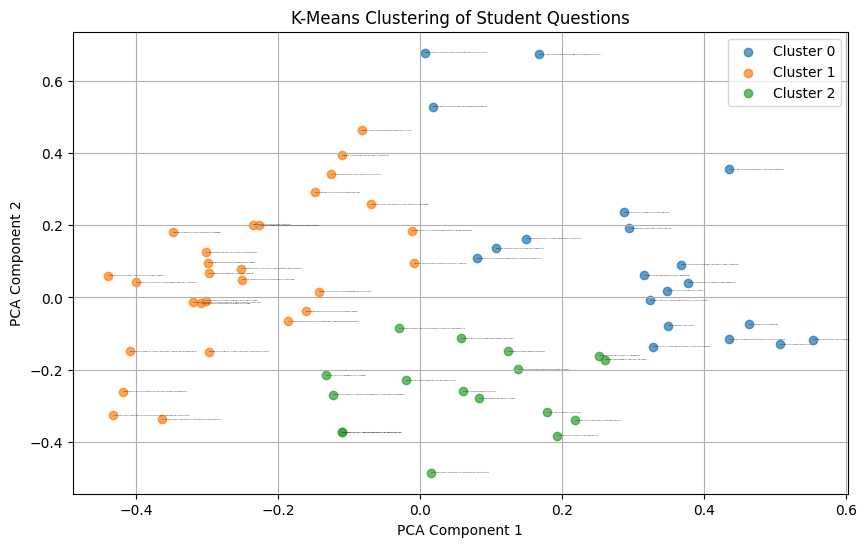

In [109]:
# Create a scatter plot colored by cluster
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab10', optimal_k)  # Get colors for each cluster

for i in range(optimal_k):
    plt.scatter(reduced_embeddings[df['cluster'] == i, 0],
                reduced_embeddings[df['cluster'] == i, 1],
                label=f'Cluster {i}', alpha=0.7)

# Annotate each point with the corresponding question
for i, question in enumerate(df['Question']):
    plt.annotate(question, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=0.0002)

plt.title('K-Means Clustering of Student Questions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

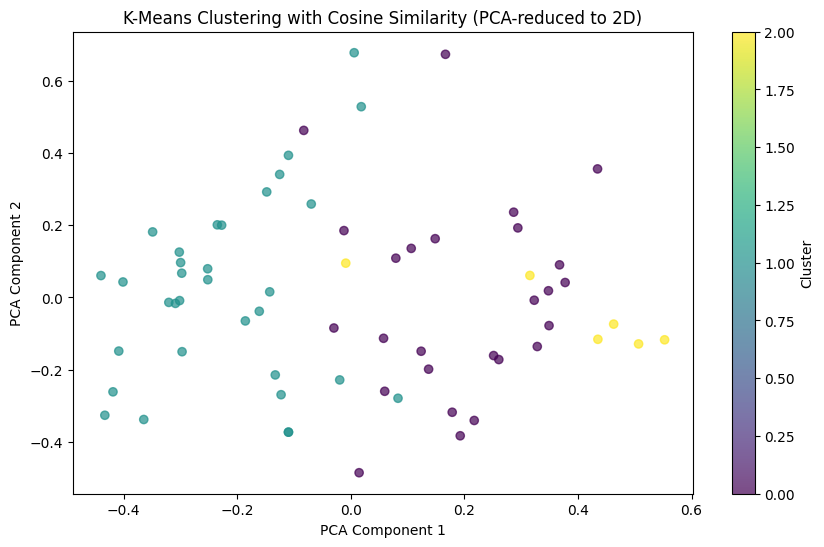

In [110]:
from sklearn.preprocessing import normalize

# Step 1: Normalize the embeddings to unit length (for cosine similarity)
normalized_embeddings = normalize(embeddings)

# Step 2: Apply K-Means clustering on the normalized embeddings
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(normalized_embeddings)

# Step 3: Get the cluster labels
labels = kmeans.labels_

# Step 4: Reduce dimensions using PCA for visualization in 2D
pca = PCA(n_components=2)
reduced_embeddings_2d = pca.fit_transform(normalized_embeddings)

# Step 5: Plot the clusters in 2D
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings_2d[:, 0], reduced_embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title('K-Means Clustering with Cosine Similarity (PCA-reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [111]:
df["kmeans"] = labels

df.sample(5)

,Unnamed: 0,Question,Label,Cleaned_Question,Topic,tokens,topic,cluster_labels,cluster,kmeans
21,21,How often does the college host national-level...,Sports,often college host nationallevel sport competi...,2,"[often, college, host, nationallevel, sport, c...",1,3,0,0
44,44,What kind of recognition or rewards are given ...,Academics,kind recognition reward given outstanding acad...,2,"[kind, recognition, reward, given, outstanding...",1,3,1,0
2,2,What kind of sports teams are there in IIT Bom...,Sports,kind sport team iit bombay,2,"[kind, sport, team, iit, bombay]",1,0,0,2
56,56,Can I get involved in organizing cultural even...,Culturals,get involved organizing cultural event festiva...,2,"[involved, organizing, cultural, event, festiv...",1,1,1,1
48,48,Can I participate in cultural teams or clubs a...,Culturals,participate cultural team club student,2,"[participate, cultural, team, club, student]",1,3,2,1


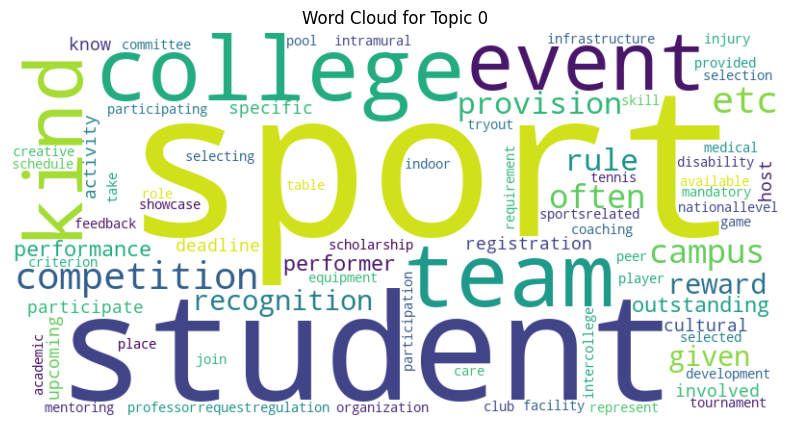

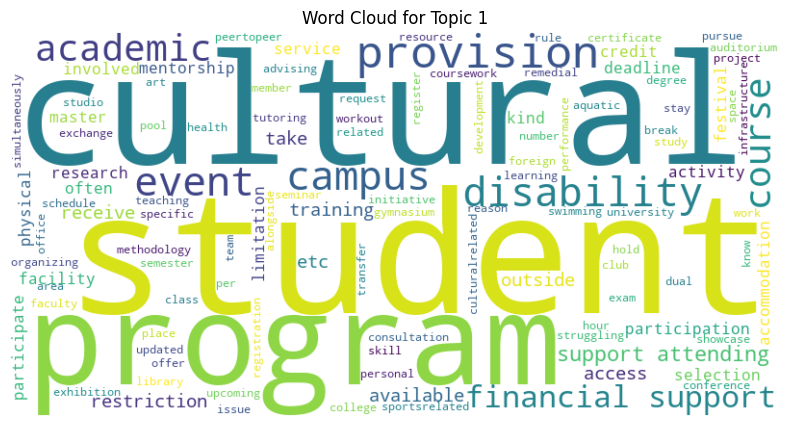

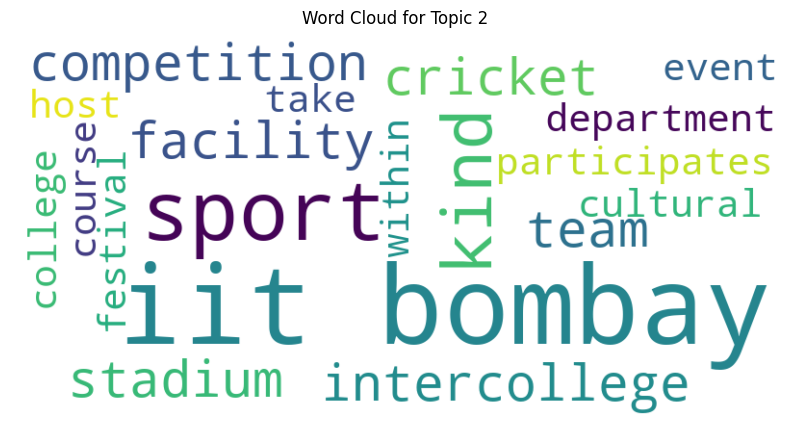

In [112]:
from wordcloud import WordCloud

# Concatenate tokens into one string for each topic
def create_word_clouds_by_topic(df):
    grouped_data = df.groupby('kmeans')['tokens'].apply(lambda x: ' '.join([' '.join(tokens) for tokens in x]))

    # Create word clouds for each topic
    for topic, tokens in grouped_data.items():
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tokens)
        
        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Topic {topic}")
        plt.show()

# Call the function
create_word_clouds_by_topic(df)

## Bertopic

In [118]:
from bertopic import BERTopic

topic_model = BERTopic(min_topic_size=2, n_gram_range=(1, 2))
topics, probabilities = topic_model.fit_transform(df["Question"].to_list())

# Add the topics back to the DataFrame
df['Assigned_Topic'] = topics

In [119]:
df[["Question", "Assigned_Topic"]]

,Question,Assigned_Topic
0,What sports facilities does IIT Bombay have?,2
1,Does IIT Bombay have a cricket stadium?,2
2,What kind of sports teams are there in IIT Bom...,2
3,Can students participate in intramural tournam...,0
4,Are sports scholarships available for students?,0
...,...,...
60,Can I request for cultural-related infrastruct...,0
61,Is there a provision for students with disabil...,0
62,How often does the college host inter-college ...,0
63,Are there any provisions for students to showc...,1


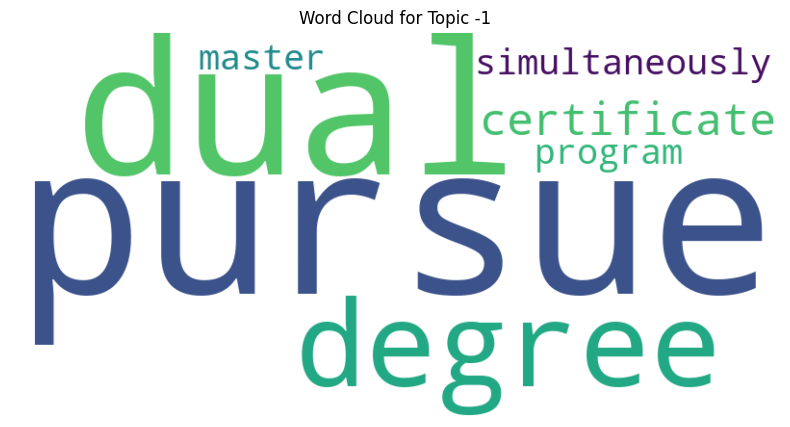

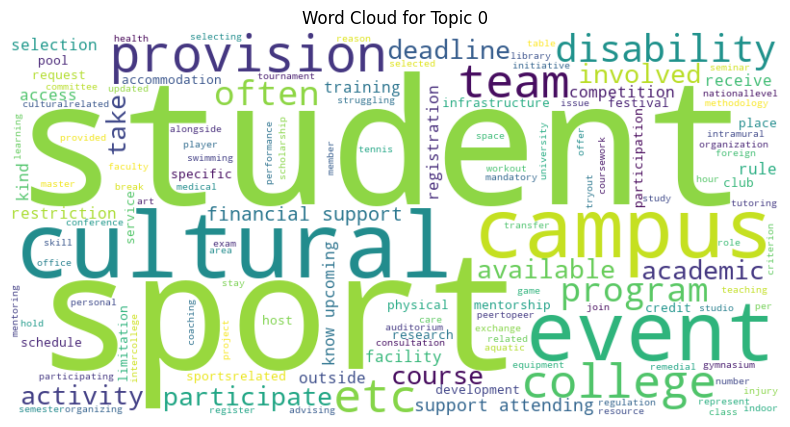

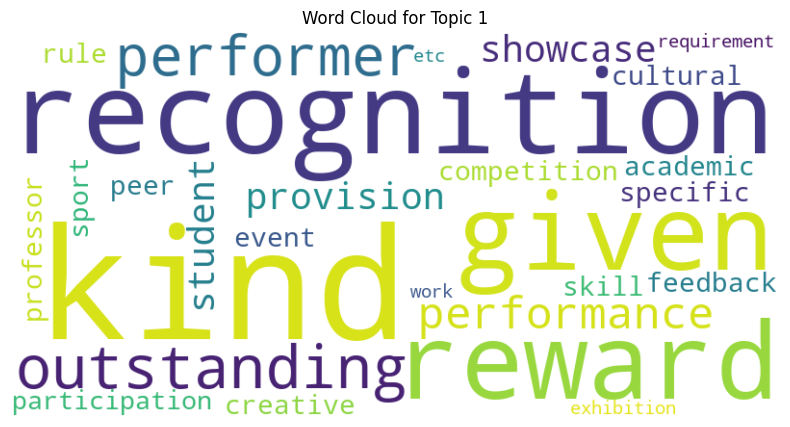

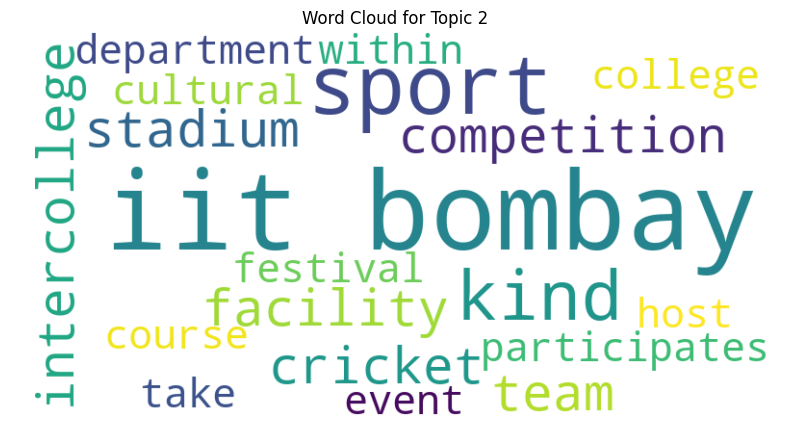

In [129]:
from wordcloud import WordCloud

# Concatenate tokens into one string for each topic
def create_word_clouds_by_topic(df):
    grouped_data = df.groupby('Assigned_Topic')['tokens'].apply(lambda x: ' '.join([' '.join(tokens) for tokens in x]))

    # Create word clouds for each topic
    for topic, tokens in grouped_data.items():
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tokens)
        
        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Topic {topic}")
        plt.show()

# Call the function
create_word_clouds_by_topic(df)

## Embedding and Retrieval

In [56]:
from PyPDF2 import PdfReader
import numpy as np

In [80]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [10]:
path = r"/Users/saranshtiwari/Documents/Placement Preperation/Projects/ChatBot using Llama3/MtechHandbook2016_17.pdf"

text=""
pdf_reader= PdfReader(path)
for page in pdf_reader.pages:
    text+= page.extract_text()

In [77]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_text(text)

In [78]:
len(chunks)

153

In [81]:
embeddings = model.encode(chunks)

In [76]:
def cos_sim(A, B):
    return np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))

def top_chunk(question):
    query_embed = model.encode(question)
    out = []
    for i in range(embeddings.shape[0]):
        out.append(cos_sim(query_embed, embeddings[i]))
    top_3_indices = np.argsort(out)[-3:][::-1]

    return [chunks[i] for i in top_3_indices]

In [83]:
top_chunk("How can a student recieve loans from Student Welfare and Benevolent Funds??")

['MASTERS HANDBOOK  \n STUDENT WELFARE AND BENEVOLENT FUNDS  \n \nStudent can receive a loan from the  Student Welfare and Ben evolent  Funds if he/she satisfies \nthe following  eligibility:  \n1. Applicant is registered student of IITB,  \n2. Conduct of the student is good,  \n3. Department recommends the case for a loan,  \n4. His /her academic performance is satisfactory . \nCategories of loans: Broadly it is divided into two categories.  \nA) Short term loans:  \nThe loans under this category are granted for a short duration of few months and loan amount \nis to be paid back before the completion of the academic programme of the student. These \nloans are provided in th e following situations:  \n(I) In case of delay in receiving scholarship/stipend amount from the funding \nagencies like CSIR/UGC etc.  \n(II) Delay in receiving money from the parents due to genuine reasons.  \n(III) In case of foreign students delay in receiving money from the re spective countries.',
 "agencies 

In [1]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(r"/Users/saranshtiwari/Documents/Placement Preperation/Projects/ChatBot using Llama3/Department Handbook 2024-25.pdf")
pages = loader.load_and_split()

In [2]:
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
documents = text_splitter.split_documents(pages)

In [3]:
from sentence_transformers import SentenceTransformer
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma

embedding_function = HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')

# List of documents (already split into chunks)
document_texts = [doc.page_content for doc in documents]
db = Chroma.from_texts(document_texts, embedding_function)

/Users/saranshtiwari/Documents/Placement Preperation/.venv/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/var/folders/4y/skt5fj3x3gb1fb25wsg55_6m0000gn/T/ipykernel_16282/1695994578.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')


In [5]:
# Perform similarity search with correct 'k' argument (not 'top_k')
query = "Tell me something about ISCP Team in IIT Bombay?"
docs = db.similarity_search(query, k=3)

retrieved_contexts = "\n\n".join([doc.page_content for doc in docs[:3]]) 
# Print the top document chunk content
print(retrieved_contexts)

"To live a fulfilled life, we need to keep creating the 'what is next' of our lives." ~
Mark Twain
Once again, congratulations on your admission to IIT Bombay, and best of luck
on your academic journey! With the support of programs like ISCP and your
dedication, we are sure you will make the most of your time on campus and
create lasting memories. Welcome to the IIT family, where excellence thrives,
and dreams become a reality.
Warm Regards,
Tarun Neelesh | Shalley Jain| Kruthik Prem Gowda 
Overall Coordinators Institute Student Companion Program (2024-25)
Indian Institute of Technology Bombay Mumbai, India
+91 7708974254 | +91 8595531604 | +91 7624815066

TABLE OF CONTENTS
01The Introduction
About the Institute: About IIT Bombay  |  1
About Department of Mathematics  |  2
About Institute Student Companion Program (ISCP)  |  3
 
02The Introductory Messages
Message from Faculty Advisors  |  4
Message from Overall Coordinators  |  5
Message from the Post Graduate Academic Council  |  7
M